# Ensemble Models
## Hypertuning

## Imports

In [1]:
## Basic Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [2]:
# NLP processing 
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
# sklearn models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Constants

In [4]:
# File path
SAMPLE_PATH = '..\data\clean\electronics_sample.csv'

# Dtypes and data column
DTYPES = {
    'overall':np.int16,
    'vote':np.int64,
    'verified':bool,
    'reviewText':object,
    'summary':object
}

## Functions

In [5]:
# preprocessing text
def lemma(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.is_alpha and token.lemma_ != '-PRON-'])

## Load data

In [6]:
## Loading Data
df = pd.read_csv(SAMPLE_PATH, dtype=DTYPES, parse_dates=[2]).dropna()
df.head()

,overall,vote,reviewTime,reviewText,summary
0,2,0,2010-02-10,Tech support is the worst,1265760000
1,2,0,2016-10-24,Screws were missing from the bracket and beaut...,Spend a little more and get much better.
2,1,0,2017-07-10,Trouble connecting and staying connected via b...,1499644800
3,4,5,2013-05-02,I purchased this unit for our RV to replace an...,Receiver Offers a Lot of Flexibility & Complexity
4,3,0,2013-01-04,It works. Nuff said but the review requires 1...,It's a cable


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19808 entries, 0 to 19808
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   overall     19808 non-null  int16         
 1   vote        19808 non-null  int64         
 2   reviewTime  19808 non-null  datetime64[ns]
 3   reviewText  19808 non-null  object        
 4   summary     19808 non-null  object        
dtypes: datetime64[ns](1), int16(1), int64(1), object(2)
memory usage: 812.4+ KB


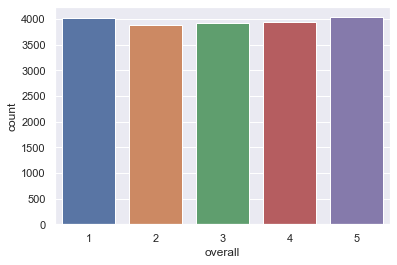

In [8]:
sns.countplot(x='overall', data=df)
plt.show()

In [9]:
# Getting read of reviews that include information about the number of stars or 
# those below 6 words
war_1 = df.reviewText.str.contains('one star')
war_2 = df.reviewText.str.contains('two star')
war_3 = df.reviewText.str.contains('three star')
war_4 = df.reviewText.str.contains('four star')
war_5 = df.reviewText.str.contains('five star')
war_6 = (df.reviewText.str.split().str.len() > 5)

mask = (~war_1 & ~war_2 & ~war_3 & ~war_4 & ~war_5 & war_6)
df = df[mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12242 entries, 1 to 19807
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   overall     12242 non-null  int16         
 1   vote        12242 non-null  int64         
 2   reviewTime  12242 non-null  datetime64[ns]
 3   reviewText  12242 non-null  object        
 4   summary     12242 non-null  object        
dtypes: datetime64[ns](1), int16(1), int64(1), object(2)
memory usage: 502.1+ KB


## Baseline Model

In [10]:
X = df['reviewText']
y = df['overall']-1

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

In [12]:
# creating tfidf model
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [13]:
print('Vocabulary Size: ', len(tfidf.get_feature_names()))

Vocabulary Size:  494


In [14]:
gb = GradientBoostingClassifier(n_estimators=100, max_depth=20)
gb.fit(X_train_tfidf, y_train)
gb.score(X_test_tfidf, y_test)

0.34463046141282155

In [15]:
y_test_pred_gb = gb.predict(X_test_tfidf)

In [16]:
cl_report_gb = pd.DataFrame(classification_report(y_test, y_test_pred_gb, output_dict=True)).T
display(cl_report_gb)

,precision,recall,f1-score,support
0,0.465455,0.488550,0.476723,524.00000
1,0.298305,0.342412,0.318841,514.00000
2,0.268657,0.282353,0.275335,510.00000
3,0.301205,0.264271,0.281532,473.00000
4,0.399441,0.334112,0.363868,428.00000
accuracy,0.344630,0.344630,0.344630,0.34463
macro avg,0.346613,0.342340,0.343259,2449.00000
weighted avg,0.346130,0.344630,0.344225,2449.00000


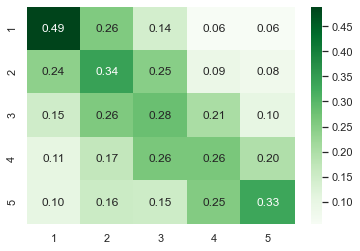

In [17]:
cm_gb = confusion_matrix(y_test, y_test_pred_gb, normalize='true')
sns.heatmap(cm_gb, cmap='Greens',
                yticklabels=range(1,6),
                xticklabels=range(1,6),
                annot=True, 
                fmt='.2f'
                )
plt.show()

## Hyperparameter Tuning
## Informed Search - Coarse to Fine 
### Randomized Search to Grid Search

In [18]:
# Creating Pipeline

steps = [('vectorizer', TfidfVectorizer()),
         ('classifier', GradientBoostingClassifier())]

pipe = Pipeline(steps)

In [19]:
params = {#'vectorizer': [TfidfVectorizer(), CountVectorizer()],
          'vectorizer__max_df':[0.8,0.9,0.99,1.],
          'vectorizer__min_df':[0.001, 0.01, 0.],
          'vectorizer__max_features':[1_000, 10_000],
          'vectorizer__ngram_range':[(1,1),(1,2)],
          #'classifier': [RandomForestClassifier(), GradientBoostingClassifier()],
          'classifier__n_estimators':[100,200,500],
          'classifier__max_depth':[5,8,10,20,50,100],
          'classifier__max_features':[0.4,0.6,0.8,1.],
          'classifier__subsample':[0.4,0.6,0.8,1.]
           }

In [20]:
search = RandomizedSearchCV(pipe, 
                            param_distributions=params,
                            n_iter=50,
                            cv=3)

In [25]:
results = pd.read_csv('../data/rand_search_result.csv', index_col=0)

In [28]:
results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectorizer__ngram_range,param_vectorizer__min_df,param_vectorizer__max_features,param_vectorizer__max_df,param_classifier__subsample,param_classifier__n_estimators,param_classifier__max_features,param_classifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,7.274837,0.173739,0.087307,0.004203,"(1, 2)",0.010,1000.0,0.80,0.6,100,1.0,5,"{'vectorizer__ngram_range': (1, 2), 'vectorize...",0.361319,0.350825,0.354354,0.355499,0.004360,1
39,4.389274,0.180909,0.056082,0.001633,"(1, 1)",0.000,1000.0,0.90,0.6,50,0.6,10,"{'vectorizer__ngram_range': (1, 1), 'vectorize...",0.353823,0.353823,0.339339,0.348995,0.006828,2
35,3.486257,0.206723,0.060023,0.002012,"(1, 1)",0.001,10000.0,0.99,0.4,100,0.4,5,"{'vectorizer__ngram_range': (1, 1), 'vectorize...",0.367316,0.340330,0.336336,0.347994,0.013760,3
34,7.490235,0.159799,0.062508,0.001869,"(1, 1)",0.001,1000.0,1.00,0.4,100,0.8,10,"{'vectorizer__ngram_range': (1, 1), 'vectorize...",0.353823,0.343328,0.343844,0.346998,0.004830,4
24,14.202743,0.309908,0.063058,0.001221,"(1, 1)",0.010,1000.0,0.80,0.8,100,1.0,10,"{'vectorizer__ngram_range': (1, 1), 'vectorize...",0.323838,0.347826,0.358859,0.343508,0.014620,5


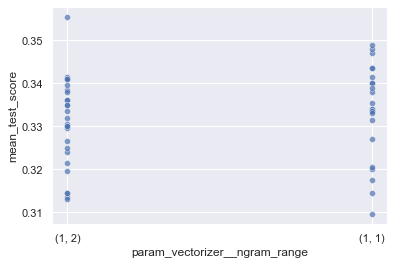

In [34]:
sns.scatterplot(x='param_vectorizer__ngram_range',y='mean_test_score',data=results, alpha=0.7)
plt.show()

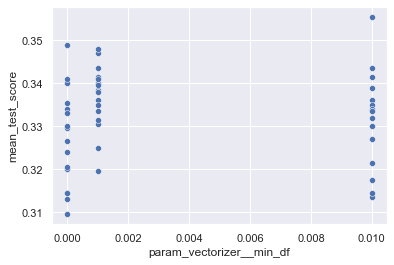

In [31]:
sns.scatterplot(x='param_vectorizer__min_df',y='mean_test_score',data=results)
plt.show()

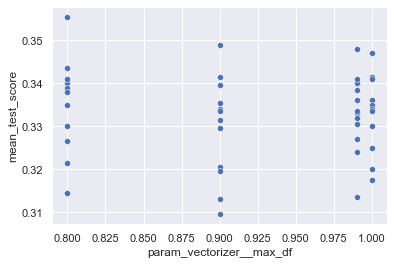

In [32]:
sns.scatterplot(x='param_vectorizer__max_df',y='mean_test_score',data=results)
plt.show()

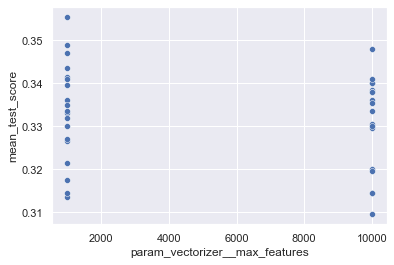

In [33]:
sns.scatterplot(x='param_vectorizer__max_features',y='mean_test_score',data=results)
plt.show()

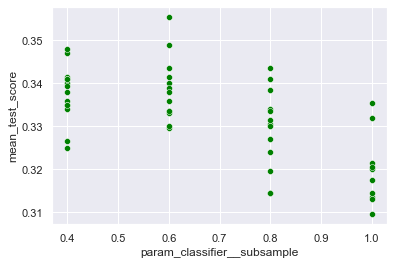

In [35]:
sns.scatterplot(x='param_classifier__subsample',y='mean_test_score',color='green', data=results)
plt.show()

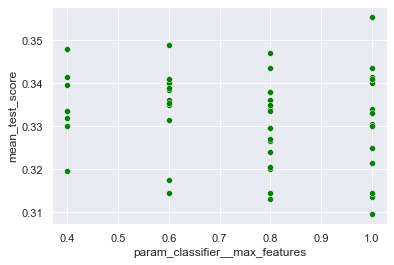

In [36]:
sns.scatterplot(x='param_classifier__max_features',y='mean_test_score',color='green', data=results)
plt.show()

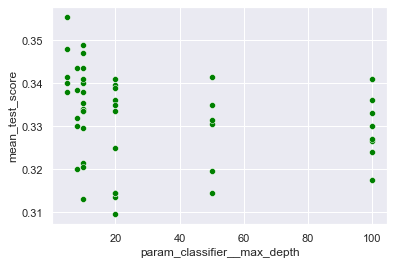

In [37]:
sns.scatterplot(x='param_classifier__max_depth',y='mean_test_score',color='green', data=results)
plt.show()

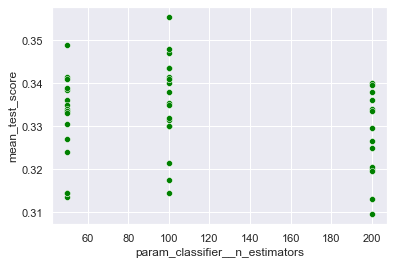

In [38]:
sns.scatterplot(x='param_classifier__n_estimators',y='mean_test_score',color='green', data=results)
plt.show()

In [39]:
params = {#'vectorizer': [TfidfVectorizer(), CountVectorizer()],
          'vectorizer__max_df':[1.],
          'vectorizer__min_df':[0.001, 0.01],
          'vectorizer__max_features':[1_000, 2_000],
          'vectorizer__ngram_range':[(1,1)],
          #'classifier': [RandomForestClassifier(), GradientBoostingClassifier()],
          'classifier__n_estimators':[100],
          'classifier__max_depth':[4,6],
          'classifier__max_features':[0.4,0.6],
          'classifier__subsample':[0.6]
           }

In [41]:
search_grid = GridSearchCV(pipe, 
                      param_grid=params,
                      cv=3)

In [42]:
search_grid.fit(X_train[:5_000], y_train[:5_000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__max_depth': [4, 6],
                         'classifier__max_features': [0.4, 0.6],
                         'classifier__n_estimators': [100],
                         'classifier__subsample': [0.6],
                         'vectorizer__max_df': [1.0],
                         'vectorizer__max_features': [1000, 2000],
                         'vectorizer__min_df': [0.001, 0.01],
                         'vectorizer__ngram_range': [(1, 1)]})

In [43]:
grid_results = pd.DataFrame(search_grid.cv_results_)

In [45]:
grid_results.sort_values(by='rank_test_score')[['params','mean_test_score','std_test_score']]

,params,mean_test_score,std_test_score
5,"{'classifier__max_depth': 4, 'classifier__max_...",0.378797,0.009750
3,"{'classifier__max_depth': 4, 'classifier__max_...",0.377199,0.005190
10,"{'classifier__max_depth': 6, 'classifier__max_...",0.376800,0.001753
2,"{'classifier__max_depth': 4, 'classifier__max_...",0.376398,0.006853
1,"{'classifier__max_depth': 4, 'classifier__max_...",0.375599,0.007160
7,"{'classifier__max_depth': 4, 'classifier__max_...",0.375197,0.012007
8,"{'classifier__max_depth': 6, 'classifier__max_...",0.373596,0.014871
4,"{'classifier__max_depth': 4, 'classifier__max_...",0.372199,0.003643
0,"{'classifier__max_depth': 4, 'classifier__max_...",0.371599,0.005322
13,"{'classifier__max_depth': 6, 'classifier__max_...",0.371200,0.006617


In [47]:
search_grid.best_params_

{'classifier__max_depth': 4,
 'classifier__max_features': 0.6,
 'classifier__n_estimators': 100,
 'classifier__subsample': 0.6,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': 1000,
 'vectorizer__min_df': 0.01,
 'vectorizer__ngram_range': (1, 1)}

In [50]:
model = search_grid.best_estimator_

In [51]:
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=1000, min_df=0.01)),
                ('classifier',
                 GradientBoostingClassifier(max_depth=4, max_features=0.6,
                                            subsample=0.6))])

In [54]:
y_test_pred = model.predict(X_test)

In [55]:
cl_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).T
display(cl_report)

,precision,recall,f1-score,support
0,0.517298,0.599237,0.555261,524.000000
1,0.321970,0.330739,0.326296,514.000000
2,0.389558,0.380392,0.384921,510.000000
3,0.369898,0.306554,0.335260,473.000000
4,0.476415,0.471963,0.474178,428.000000
accuracy,0.418538,0.418538,0.418538,0.418538
macro avg,0.415028,0.417777,0.415183,2449.000000
weighted avg,0.414087,0.418538,0.415071,2449.000000


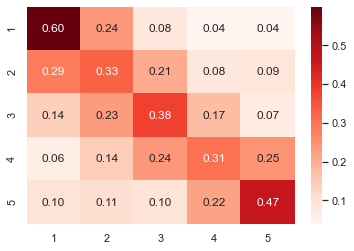

In [56]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, cmap='Reds',
                yticklabels=range(1,6),
                xticklabels=range(1,6),
                annot=True, 
                fmt='.2f'
                )
plt.show()

In [57]:
# saving the model
import pickle

# save the model to disk
filename = '../models/gbt_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.4185381788485096
